1. 用简单的网络(Pytorch CPU版本)训练cifar10数据集，得到53%左右的准确率，并保存模型为cifar10.pth
2. 加载训练过的cifar10.pth模型，并剪枝，稀疏度设置为50%，保存模型为cifar10_50%.pth
3. 加载cifar10_50%.pth模型，验证准确率，发现有所下降，再一次进行剪枝，这一次设置稀疏度为80%，保存模型为cifar10_80%.pth
4. 加载cifar10_80%.pth模型，验证准确率，发现进一步下降
解决准确率下降的办法就是训练+剪枝+训练+剪枝，不断循环

# 导入函数库

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# 设置transform, 用于对数据进行转换

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # output[channel] = (input[channel] - mean[channel]) / std[channel]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # 前者是mean, 后者是std,数值缩放到[-1,1]
])

# 加载训练集和测试集，同时进行shuffle, batch_size, transform等设置

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  # train训练集为True
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)  # shuffle训练集为True
testset = torchvision.datasets.CIFAR10(root='./data', train=False,  # train测试集为False
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)  # shuffl测试集为False

Files already downloaded and verified
Files already downloaded and verified


# 类别名称

In [4]:
classes = trainset.classes

# 图片可视化函数

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5   # 因为之前把数据缩放到了[-1,1]，这里要还原到[0,1]，再进行imshow
    npimg = img.numpy() # 转换成numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # pytorch接受的是CHW，这里要转换成HWC，再进行imshow
    plt.show()

## 可视化训练集的一个batch图片

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

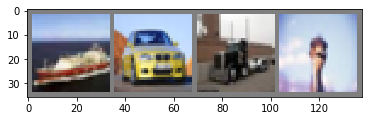

 ship automobile truck  bird


In [7]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 可视化测试集的一个batch图片

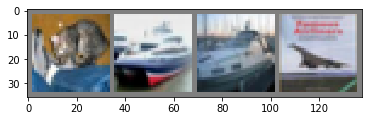

GroundTruth:    cat  ship  ship airplane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 定义网络结构

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 输入3通道，输出6通道，kernel_size=5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # cifar10是10分类，所以最后一个神经元个数是10
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 全连接层的输入为二维，这里要把卷积层的输出[batch_size,C,H,W]转化为[batch_size,C*H*W]，用的是.view()函数
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 返回logits
        return x

# 声明一个类的实例，取名net

In [10]:
net = Net()

# 加载训练过的模型

注意每次剪枝之后，这个地方的模型name要改

In [11]:
PATH = './cifar10.pth' # 注意每次剪枝之后，这个地方的模型name要改
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# 在测试集上验证模型的准确率

In [12]:
correct = 0
total = 0
with torch.no_grad():  # 推断的时候不需要计算梯度
    for data in testloader:
        images, labels = data  #此处使用的是CPU，所以不需要传送数据到GPU上
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 这个地方和平常不一样，可以自己输出看看
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


# 收集要prune的模块

In [13]:
parameters_to_prune = []

In [14]:
for name, module in net.named_modules():
    if isinstance(module, torch.nn.Conv2d): # 收集卷积模块
        parameters_to_prune.append((module, 'weight')) # 不对bias剪枝，只对weight
    elif isinstance(module, torch.nn.Linear): # 收集全连接模块
        parameters_to_prune.append((module, 'weight')) # 不对bias剪枝，只对weight

## 展示收集到的模块

In [15]:
parameters_to_prune

[(Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)), 'weight'),
 (Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)), 'weight'),
 (Linear(in_features=400, out_features=120, bias=True), 'weight'),
 (Linear(in_features=120, out_features=84, bias=True), 'weight'),
 (Linear(in_features=84, out_features=10, bias=True), 'weight')]

## 列表转化成tuple

In [16]:
parameter_to_prune = tuple(parameters_to_prune)

# 进行全局prune

每次剪枝的时候要注意这里的稀疏度设置

In [17]:
prune.global_unstructured(parameter_to_prune,  #接受的是tuple,所以上面要把列表转换成元组
                         pruning_method=prune.L1Unstructured, #采用的是L1非结构化剪枝
                         amount=0.5) # 设置的剪枝比例为0.5,也就是50%的连接会被剪去

## 我们可以看到weight变成了weight_orig

In [18]:
list(module.named_parameters())

[('bias',
  Parameter containing:
  tensor([-0.3127, -0.5018, -0.0176,  0.3172,  0.3957, -0.1549,  0.1700, -0.4057,
           0.5314, -0.2936], requires_grad=True)),
 ('weight_orig',
  Parameter containing:
  tensor([[ 0.1131, -0.0956,  0.0694,  0.1056,  0.0912, -0.1865, -0.0801, -0.0786,
            0.0307,  0.2390,  0.1167, -0.0332,  0.0715,  0.0058,  0.2710,  0.0161,
            0.1337, -0.0602,  0.0259, -0.1307, -0.1004,  0.1276, -0.0953,  0.2187,
            0.0805, -0.0107, -0.0529, -0.0437, -0.2305,  0.1482,  0.1998, -0.0290,
           -0.0852, -0.0250,  0.2457,  0.0695, -0.2443, -0.1650, -0.0120, -0.1354,
           -0.0635, -0.1189,  0.1392, -0.0949, -0.1511,  0.0354,  0.0305, -0.1015,
            0.0361, -0.0133, -0.1316,  0.2775, -0.2309,  0.2435, -0.0716,  0.0491,
            0.1291, -0.2240, -0.1170,  0.0193,  0.1302,  0.0168, -0.0805,  0.1051,
           -0.1192, -0.0886, -0.1093, -0.1193, -0.0256,  0.1999, -0.0675,  0.0771,
            0.2163, -0.1258, -0.0149, -0.0022

## 生成了buffer

In [19]:
list(module.named_buffers())

[('weight_mask',
  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
           0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
           1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
           1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
          [1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
           0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
           0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
           1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
           1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
           1., 1., 1., 1., 0., 0.

# 保存模型前要prune.remove

In [20]:
for module, name in parameter_to_prune:
    prune.remove(module, name)

In [21]:
list(module.named_parameters()) # 我们发现weight_orig变成了weight

[('bias',
  Parameter containing:
  tensor([-0.3127, -0.5018, -0.0176,  0.3172,  0.3957, -0.1549,  0.1700, -0.4057,
           0.5314, -0.2936], requires_grad=True)),
 ('weight',
  Parameter containing:
  tensor([[ 0.1131, -0.0956,  0.0694,  0.1056,  0.0912, -0.1865, -0.0801, -0.0786,
            0.0000,  0.2390,  0.1167, -0.0332,  0.0715,  0.0000,  0.2710,  0.0000,
            0.1337, -0.0602,  0.0000, -0.1307, -0.1004,  0.1276, -0.0953,  0.2187,
            0.0805, -0.0000, -0.0529, -0.0437, -0.2305,  0.1482,  0.1998, -0.0000,
           -0.0852, -0.0000,  0.2457,  0.0695, -0.2443, -0.1650, -0.0000, -0.1354,
           -0.0635, -0.1189,  0.1392, -0.0949, -0.1511,  0.0354,  0.0000, -0.1015,
            0.0361, -0.0000, -0.1316,  0.2775, -0.2309,  0.2435, -0.0716,  0.0491,
            0.1291, -0.2240, -0.1170,  0.0000,  0.1302,  0.0000, -0.0805,  0.1051,
           -0.1192, -0.0886, -0.1093, -0.1193, -0.0000,  0.1999, -0.0675,  0.0771,
            0.2163, -0.1258, -0.0000, -0.0000, -0.

In [22]:
list(module.named_buffers()) #buffers被清空了

[]

每次保存模型的时候，这里的模型name要改

In [23]:
torch.save(net.state_dict(), 'cifar10_50%.pth') #每次保存模型的时候，这里的模型name要改